In [10]:
from matplotlib import rcParams, rc
rcParams.update({'figure.autolayout': True})

import csv
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
import pandas as pd

from Tarjet import *
from Phisicsparams import *
from utils import *
from MTMM import *
from tqdm import tqdm

from multiresglonet import GLOnet
from material_database import MatDatabase


In [11]:
from typing import TypeVarTuple


params = Params()
params.thickness_sup = 0.2
params.N_layers = 10

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.materials = ['Al2O3','TiO2', 'SiO2']
params.user_define = True
if params.user_define:
  params.n_min = 1.09
  params.n_max = 2.6
  params.M_discretion_n = 200
  params.M_materials = params.M_discretion_n
  params.n_database = torch.tensor(np.array([np.linspace(params.n_min,params.n_max,params.M_discretion_n)]))
else:
  pass # definirlo en otro lado
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

params.alpha_sup =  5
params.numIter = 10
params.sigma = 0.035
params.batch_size = 50
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.net = 'Res'
params.res_layers = 16                                                                             # Cantidad de bloques Residuales del bloque ResNet
params.res_dim = 256                                                                               # Cantidad de neuronas en la capa de entrada al bloque ResNet
params.noise_dim = 26                                                                              # Dimension de la Capa de entrada
params.lr = 0.05                                                                                   # Tasa de aprendizaje del optimizador Adam (learning rate)
params.beta1 = 0.9                                                                                 # Coeficiente de decaimiento para el momento del primer orden del optimizador Adam
params.beta2 = 0.99                                                                                # Coeficiente de decaimiento para el momento del segundo orden del optimizador Adam
params.weight_decay = 0.001                                                                        # Termino de decaimiento del peso para regularizar los pesos del generador durante la optimizacion
params.step_size = 40000                                                                           # Numero de epicas despues de las cuales se reduce la tasa de aprendizaje
params.gamma = 0.5                                                                                 # El factor de reduccion para la tasa de aprendizaje. Despues de cada step_size epocas, la tasa de aprendizaje se multiplica por gamma


In [32]:
params.condiciones = 3
physicsparams = PhysicsParams(params.condiciones, user_define=True)

physicsparams.n_bot_1 = 1.4
physicsparams.n_top_1 = 1
physicsparams.k_1 = 370
physicsparams.k_values.append(physicsparams.k_1)
physicsparams.theta_1 = 45
physicsparams.lambda_min_1 = 380
physicsparams.lambda_max_1 = 750
physicsparams.pol_1 = "both"

physicsparams.n_bot_2 = 1
physicsparams.n_top_2 = 1
physicsparams.k_2 = 190
physicsparams.k_values.append(physicsparams.k_2)
physicsparams.theta_2 = 45
physicsparams.lambda_min_2 = 380
physicsparams.lambda_max_2 = 570
physicsparams.pol_2 = "TE"

physicsparams.n_bot_3 = 1
physicsparams.n_top_3 = 1
physicsparams.k_3 = 115
physicsparams.k_values.append(physicsparams.k_3)
physicsparams.theta_3 = 0
physicsparams.lambda_min_3 = 380
physicsparams.lambda_max_3 = 495
physicsparams.pol_3 = "TE"

physicsparams.generate_physics_params()
# physicsparams.view_attributes()

tarjet = Tarjet(params.condiciones, physicsparams.k_values, params.user_define)
tarjet.configure_targets()



user_define: True
k_values: [370, 190, 115]
n_bot_1: tensor([1.5000])
n_top_1: tensor([1])
k_1: tensor([16.5347, 16.4912, 16.4479, 16.4048, 16.3620, 16.3194, 16.2770, 16.2348,
        16.1929, 16.1511, 16.1096, 16.0683, 16.0272, 15.9863, 15.9456, 15.9052,
        15.8649, 15.8248, 15.7850, 15.7453, 15.7058, 15.6666, 15.6275, 15.5886,
        15.5499, 15.5114, 15.4731, 15.4350, 15.3971, 15.3594, 15.3218, 15.2844,
        15.2472, 15.2102, 15.1734, 15.1367, 15.1003, 15.0640, 15.0278, 14.9919,
        14.9561, 14.9205, 14.8851, 14.8498, 14.8147, 14.7797, 14.7449, 14.7103,
        14.6759, 14.6416, 14.6075, 14.5735, 14.5397, 14.5060, 14.4725, 14.4392,
        14.4060, 14.3729, 14.3400, 14.3073, 14.2747, 14.2422, 14.2100, 14.1778,
        14.1458, 14.1139, 14.0822, 14.0506, 14.0192, 13.9879, 13.9568, 13.9257,
        13.8949, 13.8641, 13.8335, 13.8030, 13.7727, 13.7425, 13.7124, 13.6825,
        13.6527, 13.6230, 13.5934, 13.5640, 13.5347, 13.5055, 13.4765, 13.4476,
        13.4188, 13.3901

In [4]:
if not params.user_define:
    params.matdatabase =  MatDatabase(params.materials)
    params.n_database = params.matdatabase.interp_wv(2 * math.pi/physicsparams.ks, params.materials, True)
    params.M_materials =  params.n_database.size(0)

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


iteration1


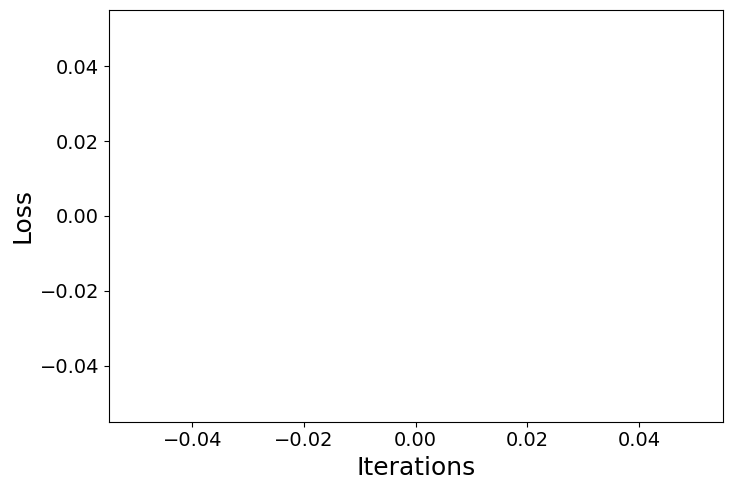

In [33]:
for seed in range(1):                                                # Generacion del comando for para las semillas (0, ->(cantidad de semillas aleatorias), 1)
  params.seed = seed

  torch.manual_seed(seed)
  glonet = GLOnet(params, physicsparams, tarjet)
  glonet.train()
  glonet.viz_training()
  print(f"iteration{seed + 1 }")


(array([-0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06]),
 [Text(0, -0.06, '−0.06'),
  Text(0, -0.039999999999999994, '−0.04'),
  Text(0, -0.019999999999999997, '−0.02'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.020000000000000004, '0.02'),
  Text(0, 0.04000000000000001, '0.04'),
  Text(0, 0.06, '0.06')])

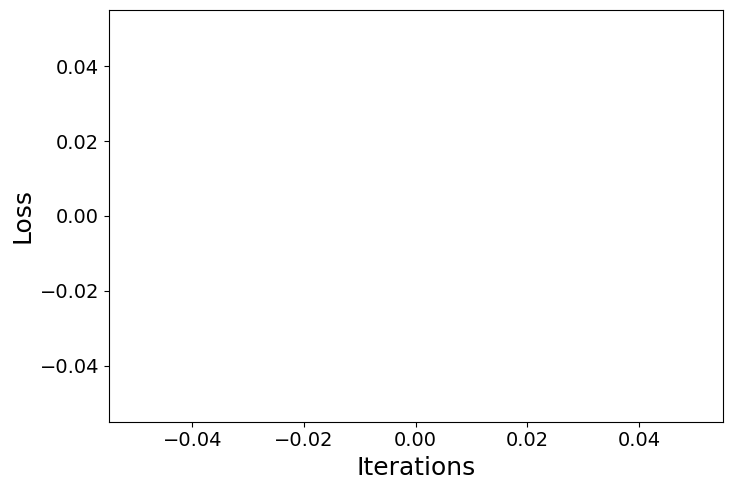

In [5]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
plt.plot(glonet.loss_training)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [70]:
with torch.no_grad():
  glonet.generator.eval()
  (thicknesses, ref_index_mat, result_mat) = glonet.evaluate(100, kvector = params.k_test,  inc_angles = params.theta_test, grayscale=False)
  FoM = torch.pow(reflection_mat - params.target_reflection.cpu(), 2).mean(dim=[1, 2, 3]) # type: ignore
  _, indices = torch.sort(FoM)
  opt_idx = indices[0]

reflection_mat_opt = reflection_mat[opt_idx].detach().cpu() # type: ignore
ref_idx_opt_mat =  ref_index_mat[opt_idx].detach().cpu()
thickness_opt = thicknesses[opt_idx].detach().cpu()

mat_opt = [params.materials[result_mat[opt_idx, i]] for i in range(result_mat.size(1))]

NameError: name 'reflection_mat' is not defined

['TiO2', 'SiO2', 'TiO2', 'SiO2', 'TiO2', 'SiO2', 'TiO2', 'SiO2', 'TiO2', 'Al2O3', 'SiO2', 'Al2O3']
torch.Size([400, 1, 1])
{'reflexion_1': tensor([0.0742, 0.0955, 0.0657, 0.0953, 0.0703, 0.0739, 0.0717, 0.1030, 0.0694,
        0.0606, 0.1001, 0.1456], grad_fn=<SelectBackward0>)}
{'reflexion_1': tensor([[3.5135, 3.5406, 3.5379,  ..., 2.3821, 2.3821, 2.3821],
        [1.4878, 1.4864, 1.4851,  ..., 1.4298, 1.4297, 1.4296],
        [3.5135, 3.5406, 3.5379,  ..., 2.3821, 2.3821, 2.3821],
        ...,
        [1.6283, 1.6283, 1.6283,  ..., 1.5571, 1.5569, 1.5567],
        [1.4878, 1.4864, 1.4851,  ..., 1.4298, 1.4297, 1.4296],
        [1.6284, 1.6284, 1.6283,  ..., 1.5571, 1.5569, 1.5568]],
       grad_fn=<SelectBackward0>)}


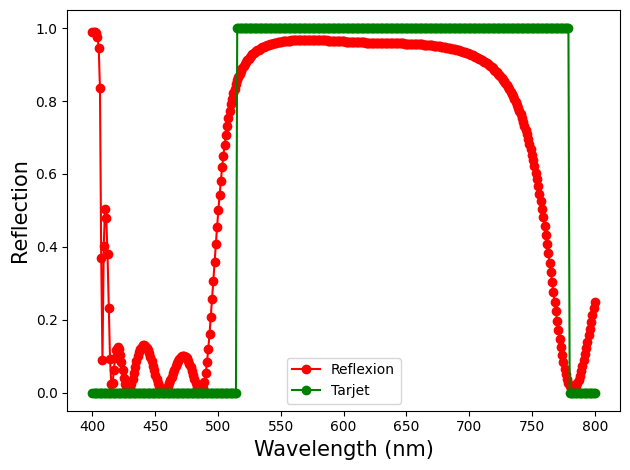

In [85]:
with torch.no_grad():
  num_devices = 6
  params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, physicsparams.k_values[0])
  params.theta_test = torch.linspace(0, math.pi/2.25, physicsparams.k_values[0])

(thicknesses, ref_index_mat, result_mat) = glonet.evaluate(100, kvector = params.k_test,  inc_angles = params.theta_test, grayscale=False)
(optimal_thicknesses, optimal_ref_idx, optimal_reflections) = glonet.optimizer_evaluate(num_devices, params.k_test, params.theta_test )

FoM = torch.pow(optimal_reflections["reflexion_1"] - tarjet.tarjets["tarjet_1"], 2).mean(dim=[1, 2, 3])
_, indices = torch.sort(FoM)
opt_idx = indices[0]

mat_opt = [params.materials[result_mat[opt_idx, i]] for i in range(result_mat.size(1))]
print(mat_opt)
print(optimal_reflections['reflexion_1'].shape)
print(optimal_thicknesses)
print(optimal_ref_idx)


plt.plot(2*math.pi / physicsparams.k_1 * 1000, optimal_reflections['reflexion_1'][:,0,0].detach().numpy(), "o-", color = "red", label = "Reflexion")
plt.plot(2*math.pi / physicsparams.k_1 * 1000,tarjet.tarjets["tarjet_1"].view(-1), "o-", color = "green", label =  "Tarjet")
plt.xlabel("Wavelength (nm)", fontsize = 15)
plt.ylabel("Reflection", fontsize = 15)
plt.legend(loc= "best")


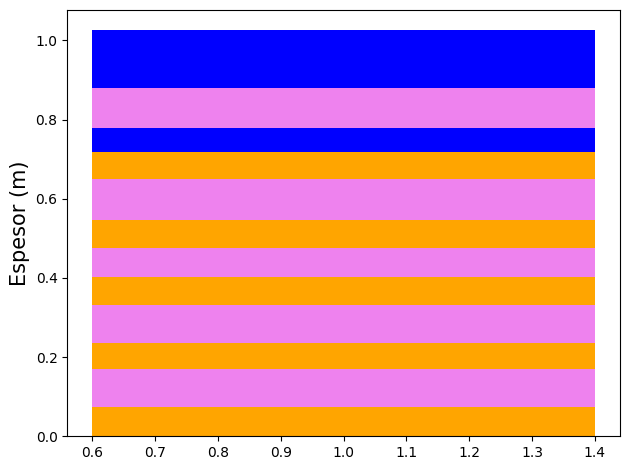

In [84]:
# Lista de espesores
espesores = optimal_thicknesses["reflexion_1"].detach().numpy()
materials = mat_opt


colores =  []
for i in range(12):
  if materials[i] == 'TiO2':
    colores.append('orange')
  elif materials[i] == 'SiO2':
    colores.append("Violet")
  elif materials[i] == 'Al2O3':
    colores.append('Blue')



# Crear la figura y el eje
fig, ax = plt.subplots()

# Calcular la suma acumulada de los espesores
espesores_acumulados = np.cumsum(espesores)

# Graficar las barras con colores diferentes
for i in range(len(espesores)):
    ax.bar(1, espesores[i], bottom=espesores_acumulados[i] - espesores[i], color=colores[i])

# Etiquetas y título

ax.set_ylabel('Espesor (m)', fontsize = 15)


# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [8]:
with torch.no_grad():
  params.k_test = 2 * math.pi / torch.linspace(0.3, 1.5, 100)
  params.theta_test = torch.linspace(0, math.pi/2.25, 80)
  glonet.generator.eval()

  z = glonet.sample_z(200)
  thicknesses, refractive_indices, P = glonet.generator(z, glonet.alpha)


  reflex = MTMM_solver(condiciones, thicknesses, refractive_indices, physicsparams) # type: ignore
  reflection_1 = TMM_solver(thicknesses, refractive_indices, physicsparams.n_bot_1, physicsparams.n_top_1 ,physicsparams.k_1, physicsparams.theta_1, physicsparams.pol_1)
  # reflection_2 = TMM_solver(thicknesses, refractive_indices, physicsparams.n_bot_2, physicsparams.n_top_2 ,params.k_test, params.theta_test, physicsparams.pol_2)

In [9]:
FoM = torch.pow(reflection_1 - tarjet.tarjets["tarjet_1"], 2).mean(dim=[1, 2, 3])
_, indices = torch.sort(FoM)

opt_idx = indices[0]
ref_idx_opt = refractive_indices[opt_idx].detach().cpu()
thickness_opt = thicknesses[opt_idx].detach().cpu()
reflection_opt = reflection_1[opt_idx].detach().cpu()

In [10]:
print(ref_idx_opt)
print(thickness_opt)


tensor([[1.2578],
        [1.7417],
        [2.6000]], dtype=torch.float64)
tensor([0.0971, 0.0716, 0.0540])


In [11]:

best_thicknesses =  torch.tensor([[ 0.562, 0.873 , 1.39]])
best_ref_indx = torch.tensor([[[2.6],[1.66],[1.15]]])


best_reflexion =  TMM_solver(best_thicknesses, best_ref_indx, physicsparams.n_bot_1, physicsparams.n_top_1 ,physicsparams.k_1, physicsparams.theta_1, physicsparams.pol_1 )
print(best_reflexion.shape)
best_reflexion[0,:,0,0]

torch.Size([1, 100, 1, 1])


tensor([0.1765, 0.4808, 0.4423, 0.4013, 0.7145, 0.4814, 0.1936, 0.6683, 0.5439,
        0.0237, 0.5557, 0.6053, 0.2918, 0.4752, 0.6828, 0.5992, 0.1005, 0.3260,
        0.6406, 0.6300, 0.3094, 0.0727, 0.5357, 0.6807, 0.6398, 0.4182, 0.2610,
        0.5031, 0.6358, 0.6169, 0.4224, 0.0431, 0.1977, 0.5305, 0.6518, 0.6465,
        0.5167, 0.1967, 0.0257, 0.3767, 0.6164, 0.7069, 0.7200, 0.6732, 0.5508,
        0.3489, 0.2299, 0.3454, 0.4963, 0.5742, 0.5818, 0.5204, 0.3716, 0.1379,
        0.0060, 0.1778, 0.4192, 0.5721, 0.6480, 0.6734, 0.6588, 0.6005, 0.4809,
        0.2791, 0.0517, 0.0296, 0.2476, 0.4680, 0.6084, 0.6875, 0.7287, 0.7449,
        0.7419, 0.7205, 0.6777, 0.6079, 0.5052, 0.3736, 0.2472, 0.1882, 0.2234,
        0.3108, 0.3989, 0.4642, 0.5025, 0.5153, 0.5036, 0.4666, 0.4017, 0.3070,
        0.1878, 0.0701, 0.0053, 0.0374, 0.1517, 0.2929, 0.4193, 0.5171, 0.5877,
        0.6363])

[0.04141521 0.04123649 0.04018576 0.0383731  0.03593995 0.03304205
 0.029837   0.02647519 0.02309349 0.01981112 0.0167273  0.01392042
 0.01144814 0.00934857 0.0076421  0.00633341 0.00541407 0.00486491
 0.00465853 0.00476159 0.00513683 0.00574493 0.00654595 0.00750066
 0.00857136 0.00972271 0.0109222  0.01214041 0.0133512  0.01453184
 0.01566274 0.01672756 0.0177129  0.0186081  0.01940511 0.02009805
 0.02068326 0.02115879 0.02152435 0.02178108 0.02193127 0.02197825
 0.02192625 0.02178019 0.02154555 0.0212283  0.02083475 0.02037144
 0.01984509 0.01926256 0.0186307  0.01795633 0.01724621 0.01650696
 0.01574511 0.01496692 0.01417853 0.01338577 0.01259427 0.01180941
 0.01103625 0.01027963 0.00954407 0.00883381 0.00815281 0.00750475
 0.006893   0.00632068 0.00579063 0.00530542 0.00486734 0.00447843
 0.00414053 0.00385517 0.00362371 0.00344727 0.00332676 0.00326289
 0.00325618 0.00330699 0.00341549 0.0035817  0.00380549 0.0040866
 0.00442463 0.00481908 0.00526929 0.00577454 0.00633405 0.00694

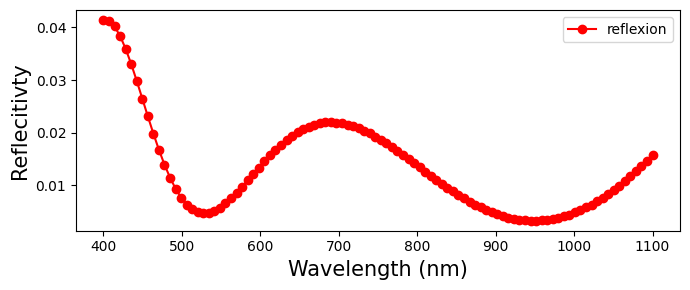

In [12]:
reflection_opt[:,0,0].view(-1).numpy()
print(reflection_opt[:,0,0].view(-1).numpy())
print(reflection_opt.shape)
plt.figure(figsize=(7,3))
plt.plot( 2*math.pi / physicsparams.k_1 *1000   ,reflection_opt[:,0,0].view(-1).numpy(), "o-", label = "reflexion", color = "red")
plt.ylabel("Reflecitivty", fontsize= 15)
plt.xlabel("Wavelength (nm)", fontsize = 15)

# plt.plot(np.arange(len(best_reflexion[0,:,0,0])),best_reflexion[0,:,0,0], "o", label = "best_reflexion")
plt.legend()